In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from model import model

In [2]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

In [3]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [4]:
structured_model1 = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)


In [5]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [6]:
def review_sentiment(state:ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model1.invoke(prompt).sentiment

    return {'sentiment': sentiment}

In [7]:
def positive_review(state:ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

In [9]:
def diagnose_issue(state: ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

In [10]:
def negative_review(state: ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [17]:
def check_sentiment(state: ReviewState)->Literal["positive_review", 'diagnose_issue']:
    if(state['review'] == 'pisitive'):
        return 'positive_response'
    else:
        return 'diagnose_issue'

In [18]:
graph = StateGraph(ReviewState)

graph.add_node('review_sentiment', review_sentiment)
graph.add_node('positive_review', positive_review)
graph.add_node('diagnose_issue', diagnose_issue)
graph.add_node('negative_review', negative_review)

#edges
graph.add_edge(START, 'review_sentiment')

graph.add_conditional_edges('review_sentiment', check_sentiment)

graph.add_edge('positive_review', END)

graph.add_edge('diagnose_issue', 'negative_review')
graph.add_edge('negative_review', END)


In [19]:
workflow = graph.compile()

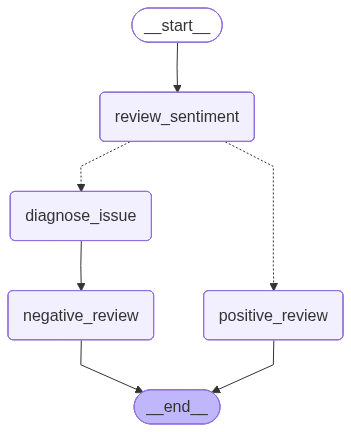

In [20]:
workflow

In [21]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: Good News: Your High-Priority Bug Has Been Resolved!\n\nHi [User Name],\n\nI'm truly sorry to hear you encountered that bug, and I completely understand how frustrating and disruptive this must have been, especially given the high urgency you reported. Dealing with unexpected issues is never ideal, and we appreciate you bringing this to our attention so quickly.\n\nI'm happy to confirm that our team has successfully identified and deployed a fix for the issue you reported. We've thoroughly tested it on our end, and it appears to be resolved.\n\nCould you please take a moment to check on your end and confirm that everythi